# Exemple d'algorithmes génétiques avec un master mind 
## Objectif :
présenter simplement les algorithmes génétiques à l'aide d'un exemple simple, un master mind !
Ce fichier sera le premier d'une songue série de notebooks sur les algorithmes génétiques. 
Il pourra m'aider à l'analyse des différentes techniques et à leurs cas d'utilisation.
L'objectif est pour la machine de deviner une combinaison en un minimum d'iterations. 
Moins il y a d'iterations, plus l'algorithme est performant.Dans le mastermind original, l'utilisateur a perdu s'il ne trouve pas la combinaison gagnante au bout d'un certain nombre d'iterations. 
Dans l'exemple ici, la machine ne peut pas perdre. L'objectif était de tester la robustesse des algorithmes.
## Règle du mastermind
Le mastermind se joue à 2 joueurs, sur un plateau de 4 colonnes et de 12 rangés et se joue avec des billes de 4 couleurs différentes.Le mastermind possède une combinaison secrète de 4 billes de couleurs, et l'objectif du joueur est de deviner avant la 13e tentative la combinaison secrète. 
Pour l'aider, il lui est révélé né nombre de billes posées au bon endroit et de la bonne couleur, sans lui reveler lesquels sont correctes.
## Ce qui est présenté dans ce notebook
- La notion de fitness
- La notion de population
- La notion d'individus
- La notion de chromosomes
- La notion de genes 

## Concepts avancée dans ce notebook
- Les types de sélections    
    - Sélection par roulette    
    - Sélection par rang    
    - Sélection par tournoi    
    - Sélection aléatoire
- La notion d'élitisme
- Les types de reproduction d'individus    
    - One point cross-over    
    - Two-point cross-over    
    - Uniforme Cross-Over

In [30]:
# Importation des librairies utilisés
import random
import numpy as np
import matplotlib.pyplot as plt

defaultProbaPerLetter = 10
batch_size = 30

In [31]:
# Definition du plateau
class Plateau:
    def __init__(self, secret):
        self.secret = secret
        self.secretLen = len(secret);
        #initialisation des genes (probabilité de 10 chaqu'un)
        self.caracteres = "azertyuiopqsdfghjklmwxcvbn0123456789_'";
        self.genesDict = []
        self.totalGenesCount = defaultProbaPerLetter*len(self.caracteres)
        # remplissage du tableau de prédiction avec la valeur par defaut.
        for i in range (0,self.secretLen):
            self.genesDict.append({});
            for l in self.caracteres:
                self.genesDict[i][l] = defaultProbaPerLetter;
        
    def printDict(self):
        print(self.genesDict)
        
    '''
    Cette fonction sert à mémoriser les résultats générés précedement. il enregistre pour chaque 
    case les résultats obtenus lors des precedentes tentatives. Cela permet à l'algorithme d'affiner lentement 
    sa prédiction pour tendre vers la bonne solution.
    '''
    def evolveGenes(self, individu, fitness):
        if (fitness == 0):
            return;
        index = 0
        for l in individu:
            self.genesDict[index][l]+= fitness
            index+=1;
        self.totalGenesCount += fitness

Il existe aussi une methode appelée uniform crossover, qui change aléatoirement les genes, dans "paquets ou coupures"distinctes. Un exemple avec les deux parents ----- et +++++ peut donner -+-+-. 
__Cet exemple n'est pas encore implémenté dans l'algorithme.__
<hr>
Voici la definition du joueur.

In [32]:
# Definition du joueur. 
# Il va jouer un coup, et le changer (muter) pour chercher une meilleur combinaision
class Joueur:
    def __init__(self, plateau):
        self.p = plateau;
        self.crossoverOne = True;
        
    # Generation d'un individu aléatoire.
    def generateRandomPlay(self):
        individu = "";
        for i in range(0,self.p.secretLen):
            lettre = p.caracteres[random.randint(0, len(p.caracteres)-1)];
            individu += lettre
        return individu;
    
    # generation d'un individu dont les genes sont probabilisé par les résultats précedents
    def generatePlay(self):
        individu = "";
        for i in range(0,self.p.secretLen):
            letterIndex = random.randint(0, p.totalGenesCount)
            for l in p.genesDict[i]:
                if (letterIndex - int(p.genesDict[i][l]) <= 0):
                    individu+=l
                    break
                else:
                    letterIndex -= p.genesDict[i][l]
        return individu;
    
    # generation d'une population de 10 individus (par defaut) avec des genes aléatoires.
    def generatePopulation(self):
        pop = [];
        for i in range(0,batch_size):
            play = self.generateRandomPlay();
            pop.append(play);
        return pop;
    
    '''
    Cette fonction genere des enfants qui possede une partie des genes de son parent.
    la generation des genes des enfant est généré par un one point crossover, ou un two point crossover.
    Le principe de mutation n'est pas introduit ici. il a pour principe de changer au hasard un gene sans 
    tenir compte de sa probabilité. Les mutations doivent etre rarent, et permettent de limiter la convergence
    de l'algorithme.
    '''
    def generatePopulationFromParent(self, parent):
        pop = [];
        for i in range(0,batch_size):
            play = self.generatePlay();
            if (self.crossoverOne):
                play = self.onePointCrossover(play);
            else:
                play = self.twoPointCrossover(play);
            pop.append(play);
        return pop;
        
    '''
    La fitness est la valeur utilisée par l'algorithme pour estimer ou noter le resultat d'un individu
    sur l'objectif à atteindre. Dans notre cas, chaque lettre correctement placée compte comme 1 point.
    La fitness maximale est donc la taille du mot secret !
    '''
    def getFitness(self, individu):
        fitness = 0;
        for i in range(0,self.p.secretLen):
            if(self.p.secret[i] == individu[i]):
                fitness += 1;
        return fitness;
    
    # retourne l'index dans la population de l'element avec la meilleur fitness 
    # (la plus haute correspondence au mot secret)
    def getFittestIndex(self, population):
        index = 0
        fittest = self.getFitness(population[index])
        for i in range(0,len(population)):
            fit = self.getFitness(population[i])
            if (fittest < fit):
                index = i;
                fittest = fit;
        return index;
    
    ''' 
    Le one point crossover est une methode de generation d'enfant.
    Admettons un parent avec le chromosome (ensemble de genes) suivant : '-----''
    Et admettons un individu généré avec les genes suivant : '+++++'
    Le one point crossover va generer l'enfant des deux parents en prennant 
    un index aléatoirement, puis en melangeant les genes du premier parent avec le second
    sur cet index.
    exemple avec l'index 2, l'enfant des deux parents ci dessus donne : '--+++'.
    '''
    def onePointCrossover(self, individu):
        side = random.randint(0, 1)
        i = random.randint(1,self.p.secretLen-1)
        play = self.generateRandomPlay()
        if (side == 0):
            ret = individu[:i] + play[:self.p.secretLen-i]
        else:
            ret = play[:i] + individu[i-self.p.secretLen:] 
        return ret;
        
    '''
    Le two point crossover sert egalement à melanger les genes de deux parents, mais cette fois-çi avec deux
    index.
    Donc pour les mêmes parents ----- et +++++ avec les index 2 et 4, l'enfant donnera : --++-.
    '''
    def twoPointCrossover(self, individu):
        i = random.randint(0,self.p.secretLen-1)
        size = random.randint(1,self.p.secretLen-i)
        play = self.generateRandomPlay()
        ret = individu[0:i] + play[i:i+size] + individu[i+size:self.p.secretLen]
        return ret;

In [33]:
# Initialisation du jeu
# Definir 5 combinaisons de 38 possibilités correspond à une chance sur 79.2 millions de tomber sur la bonne.
p = Plateau("wha0u");
j = Joueur(p);


Ici, nous allons selectionner le meilleur parent, et le faire se reproduire pour former la prochaine generation. C'est à mon sens la meilleure solution dans ce cas, car il n'existe qu'une seule solution, qui est accessible via un seul chemin. Résuire le nombre de parents permet donc de converger plus rapidement vers la meilleure solution.

Voici l'algorithme principal de la résolution du mastermind. un bref résumé de l'algorithme donne :
- Création d'une population aléatoire
- Calcul de la fitness de la population, et récuperation du meilleur individu
- Jusqu'a ce que la solution soit trouvé, faire :
    - Selectionner un parent depuis la population, 
    - Appliquer un crossover et generer une nouvelle population
    - Calculer la fitness de la nouvelle population

In [34]:
# algorithme principal :
#création d'une population de 10 individus pour le demarrage :
pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness));
p.evolveGenes(pop[fittestIndex], fitness)
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness));
    i+=1;

print("!! Trouvé !! - "+ pop[fittestIndex]+"  //  tentatives : "+str(i))

ohg2u   --fitness : 2
w1axv   --fitness : 2
g1ad9   --fitness : 1
hh8'5   --fitness : 1
'1asm   --fitness : 1
woba2   --fitness : 1
xhmli   --fitness : 1
20abi   --fitness : 1
rhtx8   --fitness : 1
wf8do   --fitness : 1
wd2dn   --fitness : 1
4hdr6   --fitness : 1
wiz6t   --fitness : 1
i6q0o   --fitness : 1
l5leu   --fitness : 1
b8i0d   --fitness : 1
g'a7k   --fitness : 1
mhz0n   --fitness : 2
wrxh4   --fitness : 1
0j7hu   --fitness : 1
vh28m   --fitness : 1
3hp0i   --fitness : 2
6sapt   --fitness : 1
iukau   --fitness : 1
1hs_j   --fitness : 1
nba3u   --fitness : 2
whw_v   --fitness : 2
nhwdz   --fitness : 1
baxyu   --fitness : 1
5hz7i   --fitness : 1
oyx08   --fitness : 1
wfkau   --fitness : 2
1ptzu   --fitness : 1
ja70t   --fitness : 1
9hkpk   --fitness : 1
7xygu   --fitness : 1
6ua2d   --fitness : 1
pfv0d   --fitness : 1
vxb2u   --fitness : 1
1mj07   --fitness : 1
9ham9   --fitness : 2
mhj0f   --fitness : 2
wna'q   --fitness : 2
zha5x   --fitness : 2
whlyi   --fitness : 2
chr6u   --

Dans l'algorithme principal au dessus, La selection du parent se fait simplement par le fait que le meilleur l'emporte. Cependant il existe plusieurs autres types de selection de parents. Nous allons en voir quelques exemples en dessous.
<hr>

# La selection par roulette
Le principe est simple. Les individus avec le plus de fitness ont plus de chance d'etre gardé pour la prochaine production de la population. illustration simple en image :

<img src="https://www.researchgate.net/profile/Manfred_Breit/publication/237507026/figure/fig7/AS:298797780488200@1448250350801/Roulette-wheel-selection-using-fitness-weighted-probability.png" alt="roulette wheel selection;">

[Source de l'image](https://www.researchgate.net/figure/Roulette-wheel-selection-using-fitness-weighted-probability_fig7_237507026)

Voici un algorithme pour le mettre en place :

In [35]:
pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness));
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex;
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness));
    i+=1;
    # calcul du total de fitness: 
    totalFitness = 0
    for J in range(0,len(pop)):
        totalFitness += j.getFitness(pop[J])
    #nombre aléatoire entier entre 0 et totalFirness :
    indexParent = random.randint(0,totalFitness);
    #Trouver l'index de l'individu à garder :
    parentIndex = 0
    for J in range(0,len(pop)):
        if (totalFitness <= 0):
            parentIndex = J;
            break;
        totalFitness -= j.getFitness(pop[J])

print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

g7adg   --fitness : 1
wda0k   --fitness : 3
eha0o   --fitness : 3
poa0u   --fitness : 3
wha0j   --fitness : 4
_3a0u   --fitness : 3
xha0q   --fitness : 3
k4e0u   --fitness : 2
wha04   --fitness : 4
wca0o   --fitness : 3
whdo0   --fitness : 2
wha0g   --fitness : 4
kta0u   --fitness : 3
4ha0k   --fitness : 3
khn05   --fitness : 2
wh8ku   --fitness : 3
0ha0b   --fitness : 3
aha0u   --fitness : 4
gha0h   --fitness : 3
fha06   --fitness : 3
wha0m   --fitness : 4
wha_5   --fitness : 3
6va0u   --fitness : 3
whf0u   --fitness : 4
nho0u   --fitness : 3
p'a0u   --fitness : 3
rla0u   --fitness : 3
40a0u   --fitness : 3
rha0h   --fitness : 3
whaxq   --fitness : 3
ora0u   --fitness : 3
1ha0u   --fitness : 4
whauu   --fitness : 4
wh86u   --fitness : 3
wha04   --fitness : 4
'ha0u   --fitness : 4
6ha08   --fitness : 3
uha0h   --fitness : 3
whw0b   --fitness : 3
qha07   --fitness : 3
bha0u   --fitness : 4
wha'x   --fitness : 3
yhaku   --fitness : 3
wha8s   --fitness : 3
mhg0u   --fitness : 3
wha0b   --

<hr>

# Sélection par rang
<img src="https://www.tutorialspoint.com/genetic_algorithms/images/rank_selection.jpg" alt="rank selection;">

[Source de l'image](https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_parent_selection.htm)

Avec cette selection, on garde un nombre fixe d'individus issu de la population ayant la meilleur fitness. une fois ces individus en nôtre pocession, on en selectionne un au hasard, puis on regénere la population.

Cette methode fonctionne avec des elements posedant une fitness negative, mais à l'inconvenient de perdre en selection naturelle rapidement, et ainsi donc privilegier les mauvais parents lors de la génération.

exemple d'algorithme ci dessous :

In [36]:
#TODO
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # calcul des n meilleurs individus de la population:
    n = 5
    arr = np.array([])
    for ind in range(0,len(pop)):
        arr = np.append(arr,j.getFitness(pop[ind]))
    #Récuperation des meilleurs index du tableau
    sortedArr = (-arr).argsort()[:n]
    # choix du prochain parent
    parentIndex = sortedArr[random.randint(0,n-1)]

print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

shc_o   --fitness : 1
cha0u   --fitness : 4
wha5u   --fitness : 4
w1a0i   --fitness : 3
w6a0u   --fitness : 4
wfa04   --fitness : 3
whafu   --fitness : 4
9ha0u   --fitness : 4
wha0s   --fitness : 4
wha0a   --fitness : 4
wha02   --fitness : 4
nha0u   --fitness : 4
wha0m   --fitness : 4
pha0x   --fitness : 3
2ha0u   --fitness : 4
eha0k   --fitness : 3
mha02   --fitness : 3
wha0v   --fitness : 4
whatw   --fitness : 3
wha0f   --fitness : 4
q7a0u   --fitness : 3
'ha0u   --fitness : 4
5za0u   --fitness : 3
_ha0u   --fitness : 4
hha0i   --fitness : 3
zya0u   --fitness : 3
wca00   --fitness : 3
whasm   --fitness : 3
whaxv   --fitness : 3
wqa0u   --fitness : 4
2ia0u   --fitness : 3
6ha0u   --fitness : 4
whaac   --fitness : 3
whalj   --fitness : 3
3ho0u   --fitness : 3
yha0x   --fitness : 3
wha09   --fitness : 4
uha0k   --fitness : 3
ova0u   --fitness : 3
wha_f   --fitness : 3
jha0u   --fitness : 4
yha0u   --fitness : 4
wha0p   --fitness : 4
whao4   --fitness : 3
wha0b   --fitness : 4
wha0c   --

<hr>

# Sélection par tournoi
<img src="https://www.tutorialspoint.com/genetic_algorithms/images/tournament_selection.jpg" alt="tournement selection;">
Avec cette selection, On selectionne K nombre d'individus, puis on les fait "se battre" entre eux, de sorte à tirer les meilleurs.

Exemple d'algorithme ci dessous :

In [37]:
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # Selection des n maximum challengers de la population:
    n = 5
    arr = []
    indArr = []
    for ind in range (0,n):
        x = random.randint(0,batch_size-1)
        arr.append(j.getFitness(pop[x]))
        indArr.append(x)
    
    # Récuperation de l'index du parent
    winnerIndex = arr.index(max(arr))
    parentIndex = indArr[winnerIndex]
    
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

0hwni   --fitness : 1
wha0e   --fitness : 4
wh20y   --fitness : 3
w_a0n   --fitness : 3
wha0s   --fitness : 4
sha0u   --fitness : 4
wha0o   --fitness : 4
bha08   --fitness : 3
wha0e   --fitness : 4
w0a0u   --fitness : 4
wha0c   --fitness : 4
jaa0u   --fitness : 3
4h50u   --fitness : 3
6ha02   --fitness : 3
eha0d   --fitness : 3
1hx0u   --fitness : 3
shf0u   --fitness : 3
6ha0u   --fitness : 4
8ha0n   --fitness : 3
fha0u   --fitness : 4
yha0u   --fitness : 4
whav4   --fitness : 3
tha0n   --fitness : 3
wua05   --fitness : 3
vhaou   --fitness : 3
fha0u   --fitness : 4
2ha0u   --fitness : 4
wha0b   --fitness : 4
uha0u   --fitness : 4
5ha00   --fitness : 3
shb0u   --fitness : 3
eha0u   --fitness : 4
wha0f   --fitness : 4
wha'4   --fitness : 3
4ha0s   --fitness : 3
uha00   --fitness : 3
m6a0u   --fitness : 3
whaod   --fitness : 3
wha0p   --fitness : 4
'ha0u   --fitness : 4
wha0m   --fitness : 4
wha77   --fitness : 3
t0a0u   --fitness : 3
wha79   --fitness : 3
3ha0u   --fitness : 4
hha0u   --

<hr>

# Sélection aléatoire
Avec cette selection, On un individu aléatoirement, pour qu'il devienne le parent de la prochaine selection.
Cette methode de selection est rarement utilisée, car elle apporte peu d'avantages à l'algorithme et amène souvent l'algorithme à s'écarter du bon chemin.

Exemple d'algorithme ci dessous :

In [38]:
pop = j.generatePopulation()
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
print(pop[fittestIndex] + "   --fitness : "+str(fitness))
p.evolveGenes(pop[fittestIndex], fitness)
parentIndex = fittestIndex
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[parentIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    p.evolveGenes(pop[fittestIndex], fitness)
    print(pop[fittestIndex] + "   --fitness : "+str(fitness))
    i+=1;
    # Selection du parent de la population:
    parentIndex = random.randint(0,len(pop)-1)
    
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

tct0p   --fitness : 1
pha0u   --fitness : 4
whanq   --fitness : 3
awa0u   --fitness : 3
wha0'   --fitness : 4
uha0t   --fitness : 3
wha44   --fitness : 3
4ha0m   --fitness : 3
wha0p   --fitness : 4
w4a0w   --fitness : 3
6ha0g   --fitness : 3
wha0g   --fitness : 4
fha0u   --fitness : 4
whazm   --fitness : 3
w3a3u   --fitness : 3
wha0y   --fitness : 4
0ha03   --fitness : 3
wha05   --fitness : 4
wha9c   --fitness : 3
wha0a   --fitness : 4
2ha0k   --fitness : 3
yha0u   --fitness : 4
wh40p   --fitness : 3
wma3u   --fitness : 3
xha0u   --fitness : 4
khg0u   --fitness : 3
hha01   --fitness : 3
wna0u   --fitness : 4
gha0u   --fitness : 4
wha0_   --fitness : 4
zha'u   --fitness : 3
aha0u   --fitness : 4
wha0i   --fitness : 4
whajs   --fitness : 3
wha09   --fitness : 4
wha0d   --fitness : 4
pha0u   --fitness : 4
wha0n   --fitness : 4
w'a0u   --fitness : 4
zha0u   --fitness : 4
wha0k   --fitness : 4
whayu   --fitness : 4
yha0u   --fitness : 4
whahq   --fitness : 3
wha0u   --fitness : 5
!! Trouvé 

# Affichage avec des graphes

## Exemple de base de l'exercice :

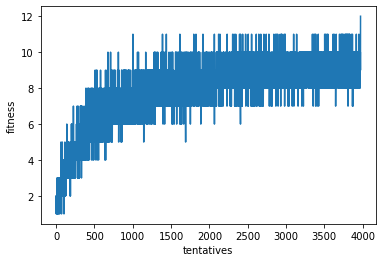

!! Trouvé !! - awes0me_p4ss  //  tentatives : 3975  // nombre d'individus testé : 119250


In [39]:
p = Plateau("awes0me_p4ss"); #38⁷ ~ 114.4 millards de possibilités
j = Joueur(p);

pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
p.evolveGenes(pop[fittestIndex], fitness)
fitnessArray = []
i=1;
while (fitness < p.secretLen):
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    fitnessArray.append(fitness)
    p.evolveGenes(pop[fittestIndex], fitness)
    i+=1;


plt.plot(fitnessArray)
plt.ylabel('fitness')
plt.xlabel('tentatives')
plt.show()
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))

## notion d'elitisme

L'elitisme est simplement le fait d'inserer le meilleur individu dans la prochaine iteration. cela permet d'empecher la regression de la fitness d'une tentative à l'autre.

cela permet d'avoir une progression constante, sans regressions.

Sur le même exemple :

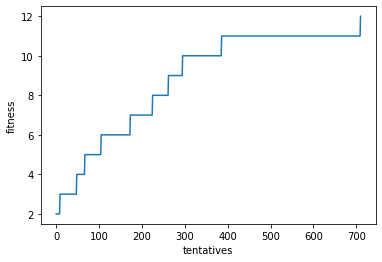

!! Trouvé !! - awes0me_p4ss  //  tentatives : 712  // nombre d'individus testé : 21360


In [40]:
p = Plateau("awes0me_p4ss");
j = Joueur(p);

pop = j.generatePopulation();
fittestIndex = j.getFittestIndex(pop)
fitness = j.getFitness(pop[fittestIndex])
p.evolveGenes(pop[fittestIndex], fitness)
fitnessArray = []
i=1;
while (fitness < p.secretLen):
    fittestIndividual = pop[fittestIndex]
    pop = j.generatePopulationFromParent(pop[fittestIndex])
    pop.append(fittestIndividual) #ajout de l'elite ici
    fittestIndex = j.getFittestIndex(pop)
    fitness = j.getFitness(pop[fittestIndex])
    fitnessArray.append(fitness)
    p.evolveGenes(pop[fittestIndex], fitness)
    i+=1;


plt.plot(fitnessArray)
plt.ylabel('fitness')
plt.xlabel('tentatives')
plt.show()
print("!! Trouvé !! - "+ pop[fittestIndex]+
      "  //  tentatives : "+str(i)+"  // nombre d'individus testé : "+str(i*batch_size))